<a href="https://colab.research.google.com/github/stefarine/DMML2022_ROLEX/blob/main/DMML_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importations, installations and statistics



##Importations & intallations

In [ ]:
!pip install -U spacy
!python -m spacy download fr
!python -m spacy download fr_core_news_sm
!pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git &> /dev/null
!pip install gensim
!pip install python-Levenshtein

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import spacy
from spacy import displacy
import nltk
import string
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils
import csv
from tqdm import tqdm
import multiprocessing


random_state=0

df = pd.read_csv('training_data.csv')
df_pred = pd.read_csv('unlabelled_test_data.csv')

In [94]:
X = df['sentence']
y = df['difficulty']
X_pred = df_pred['sentence']

##Descriptive statistics and baseline

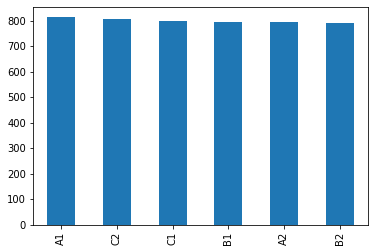

In [95]:
plot = y.value_counts().plot.bar()

In [96]:
y.describe()

count     4800
unique       6
top         A1
freq       813
Name: difficulty, dtype: object

In [97]:
base_rate = (df['difficulty'].value_counts().max()/df['difficulty'].shape[0]).round(4)
print('Base rate :')
print(base_rate)

Base rate :
0.1694


#Models

In [19]:
#Define vectorizer and split the set
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
##Models Functions

In [98]:
#Function to evaluate the model
def evaluate(true, pred):
    precision = precision_score(true, pred,average='macro')
    recall = recall_score(true, pred,average='macro')
    f1 = f1_score(true, pred,average='macro')
    print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

In [99]:
#Function to create a pipeline with TFIDF and a classifier
def pipeWithTFIDF(myClassifier):
  pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', myClassifier)])
  return pipe

In [100]:
#Function to fit a model, make pradiction with it and get evaluation stuff
def fitPredictAndEvaluateModel(pipe,name):
  # Fit model on training set
  pipe.fit(X_train, y_train)

  # Predictions
  y_pred= pipe.predict(X_test)

  #Exporting a file with the results
  y_pred.to_csv(name+".csv")

  # Evaluation
  evaluate(y_test, y_pred)

  return y_pred

In [101]:
#Function to make a gride search and print the results
def getResultsGridSearch(myGs):
  #Pipeline preparation
  pipe = pipeWithTFIDF(myGs)

  #fit
  pipe.fit(X_train, y_train)

  #Print results
  print('Best Score : ')
  print(myGs.best_score_)
  print('Best Params : ')
  print(myGs.best_params_)

In [ ]:
##Data Cleaning Functions

In [102]:
#Function to remove punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, " ")
    return text

In [103]:
from nltk.stem.snowball import SnowballStemmer

#Function for doing stemming
def return_stem(sentence):
    stemmer = SnowballStemmer(language='french')
    doc = nlp(sentence)
    return [stemmer.stem(X.text) for X in doc]

In [ ]:
## Doc2Vec Functions

In [104]:
#Function to vectorize the Train set
def vector_for_learning(model, input_docs):
    sents = input_docs
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=100)) for doc in sents])
    return targets, feature_vectors

In [105]:
#Function to vectorize the prediction Set
def vector_for_pred(model, input_docs):
    sents = input_docs
    feature_vectors = [(model.infer_vector(doc.words, steps=100)) for doc in sents]
    return feature_vectors

## Logistic Regression with TFidf vectoriser (no data cleaning)

In [107]:
#Define classifier and pipeline creation
LR = LogisticRegression(solver='lbfgs', random_state=0)
pipe_LR = pipeWithTFIDF(LR)

# fit, predict and evaluate
y_pred_LR = fitPredictAndEvaluateModel(pipe_LR,"pipe_LR")


AttributeError: ignored

## KNN & hyperparameter optimization (no data cleaning)

In [25]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

###Knn Basic

In [26]:
# Define classifier and pipeline creation
knn = KNeighborsClassifier()
pipe_knn = pipeWithTFIDF(knn)

# fit, predict and evaluate
y_pred_knn = fitPredictAndEvaluateModel(pipe_knn,"pipe_knn")

CONFUSION MATRIX:
[[121  28   8   1   1   2]
 [ 98  51  12   1   1   1]
 [ 81  39  33   3   1   3]
 [ 49  30  19  29   3  14]
 [ 48  36  29  15  29  16]
 [ 37  29  17  23   9  43]]
ACCURACY SCORE:
0.3187
CLASSIFICATION REPORT:
	Precision: 0.4007
	Recall: 0.3183
	F1_Score: 0.3022


###Knn with hyperparameter optimization 

In [27]:
#Preparation of the GridSearch
seed = 0
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

#GridSearch and Print Results
getResultsGridSearch(gs)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Score : 
0.3466145833333334
Best Params : 
{'metric': 'minkowski', 'n_neighbors': 11, 'weights': 'distance'}


In [28]:
# Define classifier and pipeline creation 
## This time we put the parameters we got in previous step
knn_GS = KNeighborsClassifier(n_neighbors = 11, weights = 'distance',metric = 'minkowski')
pipe_knn_GS = pipeWithTFIDF(knn)

# fit, predict and evaluate
y_pred_knn_GS = fitPredictAndEvaluateModel(pipe_knn_GS,"pip_knn_GS")

CONFUSION MATRIX:
[[121  28   8   1   1   2]
 [ 98  51  12   1   1   1]
 [ 81  39  33   3   1   3]
 [ 49  30  19  29   3  14]
 [ 48  36  29  15  29  16]
 [ 37  29  17  23   9  43]]
ACCURACY SCORE:
0.3187
CLASSIFICATION REPORT:
	Precision: 0.4007
	Recall: 0.3183
	F1_Score: 0.3022


##Decision Tree & Hyperparameter optimization (no data cleaning))

In [29]:
# Import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

### Decision tree Basic

In [30]:
# Define classifier and pipeline creation
dt = DecisionTreeClassifier(random_state=0)
pipe_dt = pipeWithTFIDF(dt)

# fit, predict and evaluate
y_pred_dt = fitPredictAndEvaluateModel(pipe_dt,"pipe_dt")

CONFUSION MATRIX:
[[78 38 25 11  2  7]
 [49 54 33 18  3  7]
 [24 41 37 25 18 15]
 [10 20 30 38 24 22]
 [ 8 19 31 39 39 37]
 [15 13 28 33 30 39]]
ACCURACY SCORE:
0.2969
CLASSIFICATION REPORT:
	Precision: 0.2986
	Recall: 0.2969
	F1_Score: 0.2945


###Decision Tree with hyperparameter optimization

In [31]:
#Preparation of the GridSearch
seed = 0
grid_params = {'max_depth' : range(1,60)}
gs = GridSearchCV(DecisionTreeClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

#GridSearch and Print Results
getResultsGridSearch(gs)


Fitting 3 folds for each of 59 candidates, totalling 177 fits
Best Score : 
0.32786458333333335
Best Params : 
{'max_depth': 50}


In [32]:
# Define classifier and pipeline creation
dt = DecisionTreeClassifier(max_depth=43, random_state=0)
pipe_dt_GS = pipeWithTFIDF(dt)

# fit, predict and evaluate
y_pred_dt_GS = fitPredictAndEvaluateModel(pipe_dt_GS,"pipe_dt_GS")

CONFUSION MATRIX:
[[84 34 29  7  1  6]
 [48 53 36 15  4  8]
 [34 39 38 18 17 14]
 [ 9 23 27 44 19 22]
 [14 19 27 47 35 31]
 [16 12 27 37 32 34]]
ACCURACY SCORE:
0.3000
CLASSIFICATION REPORT:
	Precision: 0.2987
	Recall: 0.3009
	F1_Score: 0.2947


## Random Forest (no data cleaning)

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
# Define classifier and pipeline creation
rf = RandomForestClassifier(random_state=0)
pipe_rf = pipeWithTFIDF(rf)

# fit, predict and evaluate
y_pred_rf = fitPredictAndEvaluateModel(pipe_rf,"pipe_rf")

CONFUSION MATRIX:
[[125  20   7   7   2   0]
 [ 83  51  21   7   2   0]
 [ 39  39  47  20   6   9]
 [ 17  11  13  68  23  12]
 [ 16  16  23  46  46  26]
 [ 19  13  10  33  23  60]]
ACCURACY SCORE:
0.4135
CLASSIFICATION REPORT:
	Precision: 0.4223
	Recall: 0.4165
	F1_Score: 0.4014


In [ ]:
LRCV = LogisticRegressionCV(solver='lbfgs',cv=5 ,max_iter=1000, random_state=0)

# Define classifier and pipeline creation
LRCV = LinearSVC(random_state=0)
pipe_LRCV = pipeWithTFIDF(LRCV)

# fit, predict and evaluate
y_pred_LRCV = fitPredictAndEvaluateModel(pipe_LRCV,"pipe_LRCV")

##LinearSVC

In [35]:
from sklearn.svm import LinearSVC

In [36]:
# Define classifier and pipeline creation
Lsvc = LinearSVC(random_state=0)
pipe_Lsvc = pipeWithTFIDF(Lsvc)

# fit, predict and evaluate
y_pred_Lsvc = fitPredictAndEvaluateModel(pipe_Lsvc,"pipe_Lsvc")

CONFUSION MATRIX:
[[96 39 15  5  3  3]
 [52 65 32  3  5  7]
 [13 38 74 10  6 19]
 [ 5 10 19 61 24 25]
 [ 8  8 16 35 66 40]
 [ 6 11  8 16 22 95]]
ACCURACY SCORE:
0.4760
CLASSIFICATION REPORT:
	Precision: 0.4767
	Recall: 0.4769
	F1_Score: 0.4737


##MultinomialNB

In [37]:
from sklearn.naive_bayes import MultinomialNB

In [38]:
# Define classifier and pipeline creation
mnb = MultinomialNB()
pipe_mnb = pipeWithTFIDF(mnb)

# fit, predict and evaluate
y_pred_mnb = fitPredictAndEvaluateModel(pipe_mnb,"pipe_mnb")

CONFUSION MATRIX:
[[ 84  44  25   4   1   3]
 [ 39  79  31   3   2  10]
 [  7  43  80   6   4  20]
 [  1  10  23  60  20  30]
 [  2   9  15  25  53  69]
 [  5  13   8  10  15 107]]
ACCURACY SCORE:
0.4823
CLASSIFICATION REPORT:
	Precision: 0.5014
	Recall: 0.4839
	F1_Score: 0.4795


##Ensembles



In [39]:
from sklearn.ensemble import VotingClassifier

In [40]:
#Definition of an ensemble with a LR and a MNB
soft_voting_clf = VotingClassifier(estimators=[('LR', pipe_LR), ('mnb', pipe_mnb) ], voting='soft')

#Train
soft_voting_clf.fit(X_train, y_train) # training

#Pred
y_pred = soft_voting_clf.predict(X_test)

#Evaluate
evaluate(y_test, y_pred)

CONFUSION MATRIX:
[[ 91  36  22   7   2   3]
 [ 48  69  30   4   4   9]
 [ 12  38  70  13   5  22]
 [  5   4  18  65  26  26]
 [  4   5  15  32  63  54]
 [  3   9  10  15  18 103]]
ACCURACY SCORE:
0.4802
CLASSIFICATION REPORT:
	Precision: 0.4829
	Recall: 0.4818
	F1_Score: 0.4773


##Doc2Vec & Logistic Regression (With data cleaning)

###Data Cleaning

#### StopWords and punctuation

In [62]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('fr_core_news_sm')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
#Convert to lowercase
df['sentence'] = df['sentence'].str.lower()
df_pred['sentence'] = df_pred['sentence'].str.lower()

#Remove punctuation
df['sentence'] = df['sentence'].apply(remove_punctuations)
df_pred['sentence'] = df_pred['sentence'].apply(remove_punctuations)

In [64]:
#Define list of stopwords
french_stopwords = spacy.lang.fr.stop_words.STOP_WORDS
french_stopwords.add('a')
french_stopwords.add('c')
french_stopwords.add('d')
french_stopwords.add('e')
french_stopwords.add('j')
french_stopwords.add('l')
french_stopwords.add('m')
french_stopwords.add('n')
french_stopwords.add('s')
french_stopwords.add('t')
french_stopwords.add('y')
french_stopwords.add('qu')

In [65]:
#Remove stopwords
df['sentence'] = df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (french_stopwords)]))
df_pred['sentence'] = df_pred['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (french_stopwords)]))
df_pred.head(10)

,id,sentence
0,0,dûmes excuser propos eûmes prononcés
1,1,pouvez savoir plaisir recevoir bonne nouvelle
2,2,paradoxalement boire froid bonne parade
3,3,étonnant saison mystérieuse
4,4,corps golo essence surnaturelle monture arrang...
5,5,jeta cri petit cri voulut dresser débattre rep...
6,6,madame monsieur fils léo arrive jours retard é...
7,7,trouvé repas midi
8,8,racine mal bel bien penser tendant manichéisme...
9,9,madame


#### Tokenization

In [66]:
#Tokenize
df['tocken_without_stopwords'] = [nlp(text) for text in df.sentence]

#add a columns with the lengh 
df['len'] = [len(token) for token in df.tocken_without_stopwords]
df.head()

,id,sentence,difficulty,tocken_without_stopwords,len
0,0,coûts kilométriques réels diverger sensiblemen...,C1,"(coûts, kilométriques, réels, diverger, sensib...",21
1,1,bleu couleur préférée aime vert,A1,"(bleu, couleur, préférée, aime, vert)",5
2,2,test niveau français site internet école,A1,"(test, niveau, français, site, internet, école)",6
3,3,mari boston,A1,"(mari, boston)",2
4,4,écoles commerce couloirs places financières ar...,B1,"(écoles, commerce, couloirs, places, financièr...",19


#### Stemming

In [70]:
#Removing the end of the worlds and adding a collumn with a numerical label
df['stemmed'] = [return_stem(text) for text in df.sentence]
df_pred['stemmed'] = [return_stem(text) for text in df_pred.sentence]
df['label'] = pd.factorize(df['difficulty'])[0] + 1
df.head()

,id,sentence,difficulty,tocken_without_stopwords,len,stemmed,label
0,0,coûts kilométriques réels diverger sensiblemen...,C1,"(coûts, kilométriques, réels, diverger, sensib...",21,"[coût, kilometr, réel, diverg, sensibl, valeur...",1
1,1,bleu couleur préférée aime vert,A1,"(bleu, couleur, préférée, aime, vert)",5,"[bleu, couleur, préfer, aim, vert]",2
2,2,test niveau français site internet école,A1,"(test, niveau, français, site, internet, école)",6,"[test, niveau, franc, sit, internet, écol]",2
3,3,mari boston,A1,"(mari, boston)",2,"[mar, boston]",2
4,4,écoles commerce couloirs places financières ar...,B1,"(écoles, commerce, couloirs, places, financièr...",19,"[écol, commerc, couloir, plac, financi, arriv,...",3


###Doc2Vec

In [ ]:
#Putting Data in a TaggedDocument format
documents = []
testdocuments = []
for ind in df.index:
  documents.append(TaggedDocument(df['stemmed'][ind],
      [df['label'][ind]]))

for ind in df_pred.index:
  testdocuments.append(TaggedDocument(df_pred['stemmed'][ind],
      tags=None))
testdocuments

In [72]:
#Creating a train set and a test set on the TaggedDocument
document_train, document_test = train_test_split(documents, test_size=0.2, random_state=0)

In [ ]:
# Preparation BagOfWords
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0)
model_dbow.build_vocab([x for x in tqdm(document_train)])
document = utils.shuffle(document_train)
model_dbow.train(documents, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [79]:
# Vectorization
y_train, X_train = vector_for_learning(model_dbow, document_train)
y_test, X_test = vector_for_learning(model_dbow, document_test)

###Linear Regression

In [92]:
# Fit model on training set
logreg = LogisticRegression(solver='lbfgs' ,max_iter=1000, random_state=0)
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

# Evaluation
evaluate(y_test, y_pred)

CONFUSION MATRIX:
[[ 87   9  20   1  30  26]
 [  1 104  19  36   1   0]
 [  5  19  80  26  22   8]
 [  1  57  40  58   6   2]
 [  7   4  27   3  87  16]
 [ 15   6  11   2  20 104]]
ACCURACY SCORE:
0.5417
CLASSIFICATION REPORT:
	Precision: 0.5550
	Recall: 0.5442
	F1_Score: 0.5420
